# Image Captioning Example

<p>The following example demonstrates an image captioning task using the SAS DLPy API. The example creates two CNN models - one to detect objects and one to generate numeric features from images. The detected object data is then parsed into numeric data and merged with the image features to create the table that will be used as input to the RNN model. The RNN model is trained using the merged table and ultimately generates caption predictions for each image in the dataset.</p>
<p>In this example, a pre-built VGG16 from the SAS DLPy package is used to generate features and a pre-trained YoloV2-Multisize model is used for object detection. Although utilized in this example, the use of object detection is optional.</p>

The example uses a small image dataset found on the DLPy GitHub which includes images and a text file containing their captions. The dataset is located in `dlpy/tests/datasources`

<p> To run this notebook, the SAS computing environment must be configured which includes:<ul>
    <li>A running CAS server</li>
    <li>A connection to CAS server</li>
    <li>SAS DLPy package</li>
    <li>Plotting requirements<ul>
        <li>Matplotlib</li>
        <li><a href="https://www.graphviz.org/">Graphviz</a></li></ul>
    </ul></p>

# Table of Contents
1. [Configure environment](#configure)
2. [Load images](#load-images)
3. [Feature Extraction](#features)
4. [Load Captions](#captions)
4. [Object Detection](#detection)
5. [Merge Tables](#merge)
6. [Create Captioning Table w/ a Single Call](#single)
7. [Build Captioning Model](#model)
8. [Train the Model](#train)
9. [Score the Captioning Table](#score)
10. [Display Predictions](#predictions)

<h3 id="configure">Configure Environment<a name="configure" /><a class="anchor-link" href="#configure"></a></h3> 

Configure your computing environment for image captioning modeling using SAS DLPy.

Import SWAT and DLPy and import the DLPy modules and functions to create the the RNN model. Use `ImageTable` for easy loading of images from a folder into a table. Import the `applications` module for the VGG16 CNN which we'll use for image feature extraction.

The `image_captioning` module contains the functions necessary for building the RNN model and the table to be used for training.

In [1]:
%matplotlib inline

from swat import *

from dlpy import *
from dlpy.images import ImageTable
from dlpy.applications import *
from dlpy.image_captioning import *

import graphviz

#### Connect to a CAS Session

<p> A connection to a running SAS CAS server is required in order to utilize the DLPy API. Connect to the server using a hostname and port number. (Username and password are also required if you have not configured an authinfo file)</p>

<div class="alert alert-block alert-info">
<b>Note:</b> For more information about starting a CAS session, click <a href="https://sassoftware.github.io/python-swat/getting-started.html">here</a>
</div>

In [2]:
conn = CAS(hostname,port)

<h3 id="load-images">Load and Process Images<a name="load-images" /><a class="anchor-link" href="#load-images"></a></h3> 

Use the imported `ImageTable` class to easily populate a CASTable with images and their info from a folder. The `img_path` represents an absolute directory path to the directory containing the images. This path <b>must</b> be accessible by the CAS server session.

In [3]:
img_path = 'dlpy/tests/datasources/imageCaptioning_images'
image_table = ImageTable.load_files(conn,path=img_path,casout=dict(name='images'))

The table `image_table` now contains the images contained in the specified folder. Verify the correct images were used by using the `show()` method.

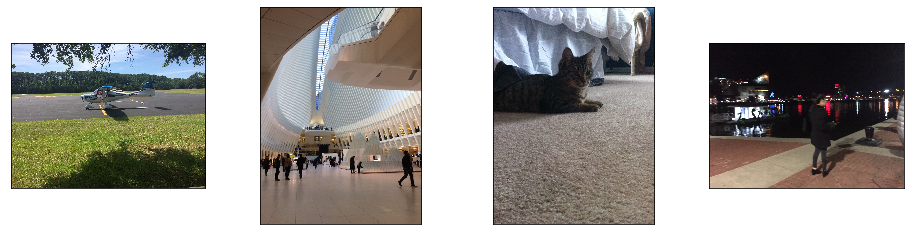

In [4]:
image_table.show(nimages=4,ncol=4,randomize=True)

The images are currently all different sizes but they will be resized in the functions `get_image_features()` and `create_embeddings_from_object_detection()` based on the heights and widths of the respective models. 

<h3 id="features">Feature Extraction<a name="features" /><a class="anchor-link" href="#features"></a></h3> 

We need to extract linear features from a specified layer in the CNN for each image. This example uses a pre-trained VGG16 model so each image will have a feature vector with a length of 4096. The features are extracted at the last layer before the output layer using the `get_features()` function from the `model` module.

Use the `applications` module to load a pre-built VGG16 and load pre-trained weights into the model.

In [6]:
VGG_pretrain_file = '/vgg16/VGG_ILSVRC_16_layers.caffemodel.h5'
features_model = VGG16(conn,model_table='VGG16',
             n_channels=3,
             width=224,
             height=224,
             scale=1,
             offsets=image_table.channel_means,
             pre_trained_weights=True,
             pre_trained_weights_file=VGG_pretrain_file,
             include_top=True)

NOTE: Model table is attached successfully!
NOTE: Model is named to "vgg16" according to the model name in the table.
NOTE: Cloud Analytic Services made the uploaded file available as table NEW_LABEL_TABLE_HJD1GE in caslib CASUSER(user@CARYNT).
NOTE: The table NEW_LABEL_TABLE_HJD1GE has been created in caslib CASUSER(user@CARYNT) from binary data uploaded to Cloud Analytic Services.
NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!


Plot the network to visualize the layers. The `get_image_features()` function requires the name of the layer to extract features from so plotting makes it easier to find the name of this layer. We will be extracting features from the `fc7` layer.

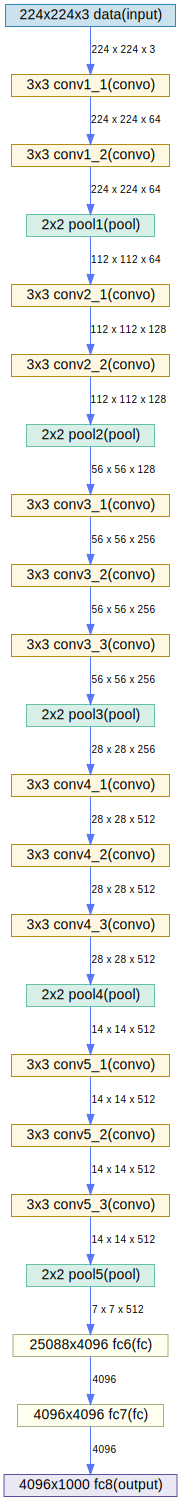

In [7]:
features_model.plot_network()

Set the dense layer name for extracting features and the target variable, which is the name of the column including the response variable. In this case, we'll use `_filename_0` so the feature vectors can be matched with their files. These are also the defaults for the function.

In [8]:
dense_layer = 'fc7'
target_var = '_filename_0'

Now we are ready to generate the features table. The `get_features()` function used in `get_image_features_table()` results in two arrays, X and y. 

X is an `n by m` size array where `n` is the number of images used for training and `m` is the size of the feature vector (in this case, m=4096). y is also length `n` and will contain the corresponding filename for each feature vector. 

The result of this function is a CASTable which combines each feature vector with its corresponding filename in each row of the table.

In [9]:
features = get_image_features(conn,
                              features_model,
                              image_table,
                              dense_layer=dense_layer,
                              target=target_var)

NOTE: Cloud Analytic Services made the uploaded file available as table TMPINQS9Q8P in caslib CASUSER(user@CARYNT).
NOTE: The table TMPINQS9Q8P has been created in caslib CASUSER(user@CARYNT) from binary data uploaded to Cloud Analytic Services.


In [10]:
features.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f4087,f4088,f4089,f4090,f4091,f4092,f4093,f4094,f4095,_filename_0
0,1.351634,0.000000,0.000000,1.587933,3.553018,1.475648,0.0,2.936592,0.000000,3.016325,...,0.0,1.268355,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,image36.jpg
1,0.916527,1.322210,0.000000,0.442242,0.912317,0.000000,0.0,1.631469,2.249745,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,image33.jpg
2,0.000000,0.000000,0.179886,0.000000,3.063791,0.292310,0.0,0.000000,2.817117,0.000000,...,0.0,1.519733,0.0,0.0,0.790017,0.363866,0.197334,0.000000,0.0,image10.jpg
3,0.127493,3.380744,0.822446,1.821973,2.002490,1.742553,0.0,0.000000,0.000000,0.000000,...,0.0,0.405030,0.0,0.0,2.215258,1.234305,1.928896,0.000000,0.0,image40.jpg
4,1.737182,1.890264,0.807223,0.000000,0.372510,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,3.875604,1.001322,4.479164,0.0,image46.jpg


<h3 id="captions">Load Captions<a name="captions" /><a class="anchor-link" href="#captions"></a></h3> 

To build the captions table, a file containing the image filenames and captions is required and the physical path to the file must be provided for the `get_captions_table()` function. A delimiter is also required for parsing the file. In the SAS provided file, the filenames and captions are tab delimited. This is also the default delimiter value.

In [11]:
captions_path = 'dlpy/tests/datasources/image_captions.txt'
delimiter = '\t'

In the output CASTable, the column name  for the captions by default is `Var{}`, but this can be changed if desired.

<div class="alert alert-block alert-warning">
    <b>Note:</b> If caption_col_name is changed from the default, it will also need to be changed in other functions, which will be noted later on.
</div>

In [12]:
captions = create_captions_table(conn,
                                 captions_path,
                                 delimiter=delimiter,
                                 caption_col_name='Var')

NOTE: Cloud Analytic Services made the uploaded file available as table TMPMN58I89H in caslib CASUSER(user@CARYNT).
NOTE: The table TMPMN58I89H has been created in caslib CASUSER(user@CARYNT) from binary data uploaded to Cloud Analytic Services.


The SAS example file contains 5 captions per image that we can see in the table below, but the captions file can contain any number of captions which will be handled within the function.

In [13]:
captions.head()

,_filename_0,Var0,Var1,Var2,Var3,Var4
0,image34.jpg,a duck begging for food from two women,a woman and her friend watching a duck,a duck lifting its head to two women to get fed,two women feeding a duck,women in winter jackets smiling while giving a...
1,image8.jpg,a girl next to a harbor,a building on a boardwalk,a woman on a boardwalk near a building and water,docks around water with a building on a sunny day,a blonde girl standing near the water
2,image43.jpg,stairs through some trees up to a building,a pathway through the woods leading to a tall ...,two men walking up stair to a building,coworkers walking on a path back to work,several flights of stairs lead up to a large g...
3,image12.jpg,a plaza surrounded by buildings,a man running across a cobblestone plaza,square cobblestone sidewalk near a building,people in a cobblestone plaza,a sidewalk in the middle of the street
4,image23.jpg,a plate of tacos with some beer,some food on a plate sitting on a table,mexican food next to a glass on a table,steak tacos next to another plate of tacos,food on a plate next to a yellow drink


<h3 id="detection">Object Detection<a name="detection" /><a class="anchor-link" href="#detection"></a></h3> 

Now that we have created tables for image features and captions, we can optionally add data from object detection. This section will use an object detection model to generate a table containing the detected objects text parsed into numeric data. In this example, we'll use a pre-trained YoloV2-Multisize model.

For the YoloV2 model, the images need to be resized to 416x416px, but this will be handled automatically within the function so we don't need to worry about resizing the images.

Now specify the full path to the `word_embeddings`. A pre-trained embeddings file is required for parsing the detected object text data into numeric data. 

In [15]:
word_embeddings = 'word_embeddings.txt'

Just like we did with the image feature generation, we need to build or specify a pre-built CNN for object detection. In this example, we use `.sashdat` files containing the model and weights information to create the model. 

Use `Model.load()` to load the model table, weights, and weight attributes in a single call by providing the path to the model table.

In [16]:
model_path = 'full_size_yolo_313_cls/multi_size_43ep/YOLOV2_MULTISIZE.sashdat'
detection_model = Model(conn)
detection_model.load(model_path)

NOTE: Model table is loaded successfully!
NOTE: Model is renamed to "yolov2_multisize" according to the model name in the table.
NOTE: YOLOV2_MULTISIZE_weights.sashdat is used as model weigths.
NOTE: Model weights attached successfully!
NOTE: YOLOV2_MULTISIZE_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!


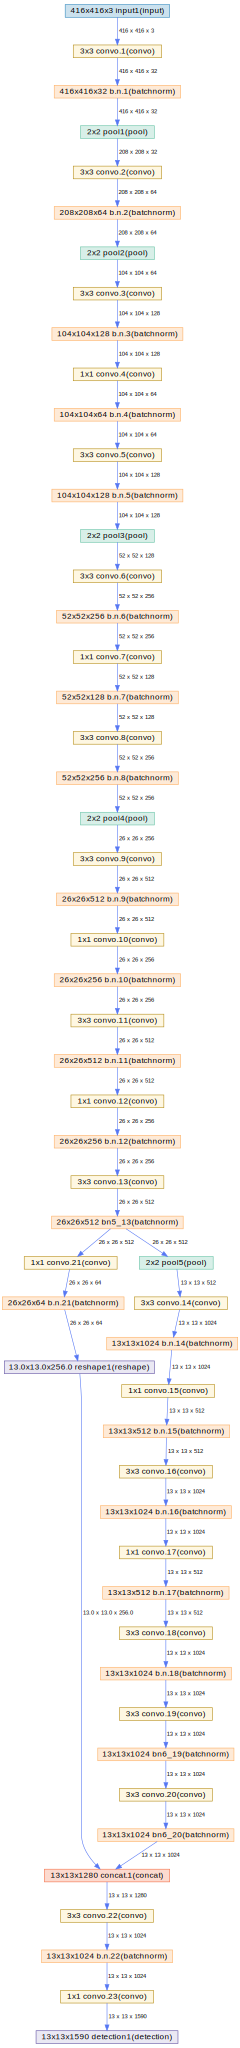

In [43]:
detection_model.plot_network()

Using the `predict()` function and the user-provided object detection model, a scoring table will be created containing specific objects within each image. The object text will then be parsed into numeric data.

In [18]:
detected_objects = create_embeddings_from_object_detection(conn,
                                                           image_table,
                                                           detection_model,
                                                           word_embeddings,
                                                           max_objects=5,
                                                           word_delimiter='\t')

NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'textparse'.
NOTE: Due to data distribution, miniBatchSize has been limited to 6.
NOTE: Cloud Analytic Services made the uploaded file available as table WORD_EMBEDDINGS in caslib CASUSER(user@CARYNT).
NOTE: The table WORD_EMBEDDINGS has been created in caslib CASUSER(user@CARYNT) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table OBJECTS in caslib CASUSER(user@CARYNT).
NOTE: The table OBJECTS has been created in caslib CASUSER(user@CARYNT) from binary data uploaded to Cloud Analytic Services.


In [19]:
detected_objects.head()

,_id_,_Sequence_length_,_F_0_0_,_F_0_1_,_F_0_2_,_F_0_3_,_F_0_4_,_F_0_5_,_F_0_6_,_F_0_7_,...,_F_8_92_,_F_8_93_,_F_8_94_,_F_8_95_,_F_8_96_,_F_8_97_,_F_8_98_,_F_8_99_,_filename_0,first_objects
0,27.0,5.0,0.38709,0.326290,0.64524,0.012882,-0.11051,1.19220,0.37298,0.12726,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image32.jpg,"Person,Person,NoObject,NoObject,NoObject,"
1,35.0,5.0,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image40.jpg,"NoObject,NoObject,NoObject,NoObject,NoObject,"
2,43.0,5.0,0.30817,0.309380,0.52803,-0.925430,-0.73671,0.63475,0.44197,0.10262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image49.jpg,"Dog,NoObject,NoObject,NoObject,NoObject,"
3,4.0,5.0,-0.18867,-0.040943,0.58878,0.110620,0.14236,0.48850,-0.31832,0.53819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image11.jpg,"House,House,House,Tree,NoObject,"
4,12.0,5.0,0.30817,0.309380,0.52803,-0.925430,-0.73671,0.63475,0.44197,0.10262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,image19.jpg,"Dog,NoObject,NoObject,NoObject,NoObject,"


<h3 id="merge">Merge Tables<a name="merge" /><a class="anchor-link" href="#merge"></a></h3> 

Up to this point, we have gathered a large amount of data about the images, including image features, objects within the images, and image captions. Now we need to combine all of this data into a format that will effectively train the RNN model. The `_filename_0` column is consistent across all three tables, so we'll be merging on that column.

Start by merging the captions and features tables using `dljoin` from the `deeplearn` actionset.

In [20]:
conn.dljoin(table=captions,
            annotatedTable=features,
            id = '_filename_0',
            casOut=dict(name='captions_features',replace=True))

,casLib,Name,Rows,Columns,casTable
0,CASUSER(user@CARYNT),captions_features,52,4102,"CASTable('captions_features', caslib='CASUSER(..."


Next merge the combined captions-features table with the objects table, again using `dljoin` 

In [21]:
conn.dljoin(table=dict(name='captions_features'),
           annotatedTable=detected_objects,
           id='_filename_0',
           casOut=dict(name='obj_capt_feats',replace=True))

,casLib,Name,Rows,Columns,casTable
0,CASUSER(user@CARYNT),obj_capt_feats,52,10078,"CASTable('obj_capt_feats', caslib='CASUSER(mac..."


In [22]:
obj_capt_feats = conn.CASTable('obj_capt_feats')

Check that the 3 tables merged successfully. The numeric object data, image feature vectors, all 5 captions, id, and filename should be present.

In [23]:
obj_capt_feats.head()

,_filename_0,Var0,Var1,Var2,Var3,Var4,f0,f1,f2,f3,...,_Object843_y,_Object843_width,_Object843_height,_Object844_,_P_Object844_,_Object844_x,_Object844_y,_Object844_width,_Object844_height,first_objects
0,image44.jpg,people looking at walls with grafitti on them,women stand in an industrial looking area with...,walls covered in grafitti surround onlooking g...,girls stand in the dirt looking at walls cover...,several women look at walls that have a lot of...,1.795433,0.000000,2.259455,0.0,...,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,"Person,Person,NoObject,NoObject,NoObject,"
1,image46.jpg,a stone arch in a park,a picture of washington square park in new yor...,people walking around a park with trees and st...,a stone plaza with people walking around near ...,washington square park with the famous white a...,1.737182,1.890264,0.807223,0.0,...,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,"Tree,Tree,Vehicle,Vehicle,Person,"
2,image47.jpg,two people standing on top of a rocky mountain,a man and a woman look at the view from the to...,people atop a rocky hill looking at the view b...,two people stand at the top of a mountain and ...,a man and woman in shorts stand on top of a mo...,0.614619,0.419221,0.000000,0.0,...,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,"Person,Person,NoObject,NoObject,NoObject,"
3,image14.jpg,people walking through the desert on a sunny day,three peole walk through the sand on a sunny day,some grass grows in the dunes as people walk a...,people walking around sand dunes on a hot summ...,people walk between the tall grass on sand in ...,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,"Person,Person,Person,Person,Person,"
4,image15.jpg,a single passenger airplane parked on a blacktop,a small airplane parked on the tarmac on a sun...,one airplane parked next to some grass and trees,a very small airplane probably for one person ...,a blue and white airplane sits on a landing st...,0.000000,0.000000,4.150983,0.0,...,NaN,NaN,NaN,NoObject,NaN,NaN,NaN,NaN,NaN,"Plant,Airplane,NoObject,NoObject,NoObject,"


Now that all the data is in the same table, we need to reformat for training. Currently there are 5 captions per row so the table layout needs to be fixed so there's only 1 caption per row.

Use the `reshape_caption_columns()` function to do this. If you changed `caption_col_name` from the default when building the caption table, make sure to also change it here. 

In [24]:
rnn_input = reshape_caption_columns(conn,
                                    obj_capt_feats,
                                    caption_col_name='Var',
                                    num_captions=5)

NOTE: Cloud Analytic Services made the uploaded file available as table TMPN6WM6BHU in caslib CASUSER(user@CARYNT).
NOTE: The table TMPN6WM6BHU has been created in caslib CASUSER(user@CARYNT) from binary data uploaded to Cloud Analytic Services.


Finally, drop any unnecessary columns and view the final table that will be used for training.

In [25]:
drop_columns = set(rnn_input.columns) - set(features.columns) - set(captions.columns) - set(detected_objects.columns)
drop_columns.remove('caption')
rnn_input.drop(drop_columns,axis=1,inplace=True)

In [26]:
rnn_input.head()

,_filename_0,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,_F_8_92_,_F_8_93_,_F_8_94_,_F_8_95_,_F_8_96_,_F_8_97_,_F_8_98_,_F_8_99_,first_objects,caption
0,image28.jpg,0.000000,5.523561,1.405951,0.529567,0.684264,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"House,Tree,Tree,NoObject,NoObject,",the sun setting turns the sky bright pink over...
1,image10.jpg,0.000000,0.000000,0.179886,0.000000,3.063791,0.292310,0.000000,0.000000,2.817117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"NoObject,NoObject,NoObject,NoObject,NoObject,",a fish swims by a girl on the ground looking a...
2,image11.jpg,1.021394,5.698648,1.334516,0.000000,2.842952,1.394671,1.122416,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"House,House,House,Tree,NoObject,",there is a large white buildinng at the top of...
3,image11.jpg,1.021394,5.698648,1.334516,0.000000,2.842952,1.394671,1.122416,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"House,House,House,Tree,NoObject,",some kind of old government building at the to...
4,image49.jpg,2.132184,1.073279,0.003856,0.000000,0.000000,0.000000,0.000000,0.029125,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Dog,NoObject,NoObject,NoObject,NoObject,",a nervous dog at the vet


<h3 id="single">Create Captioning Table with a Single Call<a name="single" /><a class="anchor-link" href="#single"></a></h3> 

The first half of this example was showing step by step how to create a table for training an RNN model for image captioning. These steps take longer but allow for more flexibility in creating the model. For an easier method, the table can also be created with a single call, using many of the same inputs. The following code uses the `create_captioning_table()` function to create the same table we just created, except in a single call.

We will reuse the inputs used in the first part of the example.

In [27]:
rnn_input_single = create_captioning_table(conn,
                                           image_table,
                                           features_model=features_model,
                                           captions_file=captions_path,
                                           obj_detect_model=detection_model,
                                           word_embeddings_file=word_embeddings,
                                           num_captions=5,
                                           dense_layer='fc7',
                                           captions_delimiter='\t',
                                           embeddings_delimiter='\t',
                                           caption_col_name='Var',
                                           objects_width=416,
                                           )

NOTE: Cloud Analytic Services made the uploaded file available as table TMP_TQZ2JWL in caslib CASUSER(user@CARYNT).
NOTE: The table TMP_TQZ2JWL has been created in caslib CASUSER(user@CARYNT) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table TMPXVRCNPHA in caslib CASUSER(user@CARYNT).
NOTE: The table TMPXVRCNPHA has been created in caslib CASUSER(user@CARYNT) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table CAPTIONS_FEATURES in caslib CASUSER(user@CARYNT).
NOTE: The table CAPTIONS_FEATURES has been created in caslib CASUSER(user@CARYNT) from binary data uploaded to Cloud Analytic Services.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'textparse'.
NOTE: Due to data distribution, miniBatchSize has been limited to 6.
NOTE: Cloud Analytic Services made the uploaded file available as table WORD_EMBEDDINGS in caslib CASUSER(use

We don't need to drop any columns here as that was handled within the function call. The table should look identical to the one we just created above. 

In [28]:
rnn_input.head()

,_filename_0,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,_F_8_92_,_F_8_93_,_F_8_94_,_F_8_95_,_F_8_96_,_F_8_97_,_F_8_98_,_F_8_99_,first_objects,caption
0,image28.jpg,0.000000,5.523561,1.405951,0.529567,0.684264,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"House,Tree,Tree,NoObject,NoObject,",the sun setting turns the sky bright pink over...
1,image10.jpg,0.000000,0.000000,0.179886,0.000000,3.063791,0.292310,0.000000,0.000000,2.817117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"NoObject,NoObject,NoObject,NoObject,NoObject,",a fish swims by a girl on the ground looking a...
2,image11.jpg,1.021394,5.698648,1.334516,0.000000,2.842952,1.394671,1.122416,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"House,House,House,Tree,NoObject,",there is a large white buildinng at the top of...
3,image11.jpg,1.021394,5.698648,1.334516,0.000000,2.842952,1.394671,1.122416,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"House,House,House,Tree,NoObject,",some kind of old government building at the to...
4,image49.jpg,2.132184,1.073279,0.003856,0.000000,0.000000,0.000000,0.000000,0.029125,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Dog,NoObject,NoObject,NoObject,NoObject,",a nervous dog at the vet


<h3 id="model">Build Captioning Model<a name="model" /><a class="anchor-link" href="#model"></a></h3> 

Now that the captioning table has been created from the two CNNs, we need to use DLPy to build an RNN model to train for image captioning. Use the DLPy `ImageCaptioning()` function to create an RNN. By default, the model will have 50 neurons and 3 LSTM layers with `samelength` output. 

<p>The RNN model consists of:<ul>
    <li>Input layer</li>
    <li>Recurrent LSTM layers w/ same length output</li>
    <li>Recurrent LSTM layer w/ encoding output</li>
    <li>Recurrent LSTM layer w/ arbitrary length output</li>
    <li>Output layer</li></ul>
</p>

The `max_output_len` is used in the last recurrent layer and determines the maximum length of the predicted captions. Use `get_max_capt_len()` to get the max caption length from the captions file and use for the `max_output_len` value.

In [29]:
captioning_model = ImageCaptioning(conn,model_name='image_captioning',
                                  num_blocks=3,
                                  neurons=50,
                                  rnn_type='LSTM',
                                  max_output_len=get_max_capt_len(captions_path))

NOTE: Input layer added.
InputLayer added named "input"
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.
OutputLayer added named "output"


Use `plot_network()` to view the network layout. 

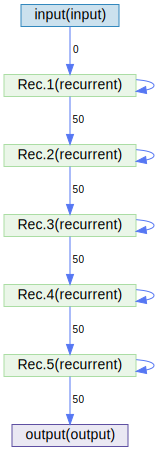

In [30]:
captioning_model.plot_network()

If available, load pre-trained weights into the CAS session. 

In [31]:
conn.loadtable(path='trained_weights.sashdat', casout=dict(name='trainedWeights', replace=True))

NOTE: Cloud Analytic Services made the file trained_weights.sashdat available as table TRAINEDWEIGHTS in caslib CASUSER(user@CARYNT).


[caslib]

 'CASUSER(user@CARYNT)'

[tableName]

 'TRAINEDWEIGHTS'

[casTable]

 CASTable('TRAINEDWEIGHTS', caslib='CASUSER(user@CARYNT)')

+ Elapsed: 0.866s, sys: 0.0156s, mem: 0.692mb

Set the weights in the model.

In [32]:
captioning_model.set_weights('trainedWeights')

NOTE: Model weights attached successfully!


<h3 id="train">Train the Model<a name="train" /><a class="anchor-link" href="#train"></a></h3> 

Create a list `input_vars` of columns that will be used as input to the model. The data must be all numeric and should be relevant to the image contents so this will cover all columns in the table except for caption, filename, objects, and id. 

In [33]:
columns = list(rnn_input.columns)
columns.remove('caption')
columns.remove('_filename_0')
columns.remove('_id_')
columns.remove('first_objects')
input_vars = columns

Finally we can train the model. Use Dlpy's `fit()` function to train the RNN model `captioning_model`. Since the model takes numeric input and gives text output, it uses a `numericnominal` input layer and a `text` output layer. Use the 'word_embeddings' table, originally loaded for object detection, for `init_input_embeddings`in `text_parms`.

<p>The training saves the best weights, which can be used for scoring data later, and uses the following hyperparameters:</p><ul>
    <li>learningRate = .01</li>
    <li>mini_batch_size = 20</li>
    <li>max_epochs = 200</li>
</ul></p>

In [34]:
captioning_model.fit(rnn_input,inputs=input_vars,
                    data_specs=[
                        dict(type='numericnominal',layer='input',data=input_vars,numericNominalParms=dict(tokensize=100)),
                        dict(type='text',layer='output',data='caption')],
                     save_best_weights=True,
                     text_parms = TextParms(init_input_embeddings='word_embeddings',
                                           model_output_embeddings=dict(name='keyed_glove',replace=True)),
                     seed=12345,
                     optimizer=Optimizer(algorithm=dict(method='ADAM',learningRate=.01),
                                         mini_batch_size=20,
                                         log_level=2,
                                         max_epochs=200),
                     n_threads=50
                     )

NOTE: Training based on existing weights.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 157148.
NOTE:  The approximate memory cost is 203.00 MB.
NOTE:  Loading weights cost       0.02 (s).
NOTE:  Initializing each layer cost       6.82 (s).
NOTE:  The total number of threads on each worker is 8.
NOTE:  The total mini-batch size per thread on each worker is 20.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 160.
NOTE:  Target variable: caption
NOTE:  Number of levels for the target variable:      1
NOTE:  Levels for the target variable:
NOTE:  Number of input variables:  4996
NOTE:  Number of numeric input variables:   4996
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  0          0.01           21.04     0.9975     0.60
NOTE:  1          0.01           19.82     0.9945     0.25
NOTE:  2          0.01           18.65     0.9914     0.24
NOTE:  3          0.01           17.69     0.9907     0.23
NOTE:  

NOTE:  125        0.01           1.527     0.3404     0.24
NOTE:  126        0.01           1.514     0.3346     0.24
NOTE:  127        0.01             1.5     0.3359     0.26
NOTE:  128        0.01           1.483     0.3284     0.24
NOTE:  129        0.01           1.469     0.3277     0.24
NOTE:  130        0.01           1.451     0.3235     0.25
NOTE:  131        0.01           1.435     0.3219     0.24
NOTE:  132        0.01            1.42     0.3176     0.25
NOTE:  133        0.01           1.406     0.3142     0.26
NOTE:  134        0.01            1.39     0.3108     0.24
NOTE:  135        0.01           1.376     0.3086     0.23
NOTE:  136        0.01           1.363     0.3066     0.24
NOTE:  137        0.01           1.351     0.3019     0.24
NOTE:  138        0.01           1.338     0.3011     0.25
NOTE:  139        0.01           1.326     0.2949     0.25
NOTE:  140        0.01           1.313     0.2945     0.26
NOTE:  141        0.01           1.301     0.2901     0.

,Descr,Value
0,Model Name,image_captioning
1,Model Type,Recurrent Neural Network
2,Number of Layers,7
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,5
9,Number of Weight Parameters,155650


<h3 id="score">Score the Captioning Table<a name="score" /><a class="anchor-link" href="#score"></a></h3> 

Now use the `predict()` function using the best weights from training. The scoring task seeks to generate text from the features in the data. 

In [35]:
captioning_model.predict(rnn_input,
                         text_parms=dict(initOutputEmbeddings='keyed_glove',hasOutputTermIds=True,
                                        initInputEmbeddings='word_embeddings',hasInputTermIds=False,
                                        embeddingTrainable=False),
                          use_best_weights=True
                         )

NOTE: Using the weights providing the smallest loss error.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           240
 1  Number of Observations Used           240
 2  Misclassification Error (%)      85.22104
 3                   Loss Error      9.530968

[OutputCasTables]

                    casLib              Name  Rows  Columns  \
 0  CASUSER(user@CARYNT)  Valid_Res_LwEYjW   240     5849   
 
                                             casTable  
 0  CASTable('Valid_Res_LwEYjW', caslib='CASUSER(m...  

+ Elapsed: 3.14s, user: 2.92s, sys: 0.562s, mem: 160mb

Save the results from scoring so we can use them for showing caption predictions. 

In [36]:
results = captioning_model.valid_res_tbl

Check the table to see the final results. The caption predictions are in the column `_DL_Pred_`

In [37]:
results.head()

,_filename_0,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,_P_Object838_,_P_Object839_,_P_Object840_,_P_Object841_,_P_Object842_,_P_Object843_,_P_Object844_,first_objects,caption,_DL_Pred_
0,image8.jpg,1.47273,3.751651,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"House,Person,Dress,NoObject,NoObject,",a woman on a boardwalk near a building and water,a blonde girl standing near the water
1,image8.jpg,1.47273,3.751651,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"House,Person,Dress,NoObject,NoObject,",docks around water with a building on a sunny day,a blonde girl standing near the
2,image8.jpg,1.47273,3.751651,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"House,Person,Dress,NoObject,NoObject,",a blonde girl standing near the water,a blonde girl standing near the water
3,image13.jpg,0.00000,0.000000,0.0,0.0,1.171132,0.0,0.0,0.202303,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Boat,Boat,Person,Boat,NoObject,",two women tubing bounce on the water as a boat...,two girls tubing on a lake
4,image43.jpg,0.00000,5.926673,0.0,0.0,1.156839,0.0,0.0,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Stairs,Tree,Tree,Tree,Tree,",two men walking up stair to a building,two men walking up stair to a building


<h3 id="predictions">Display Predictions<a name="predictions" /><a class="anchor-link" href="#predictions"></a></h3> 

`display_predicted_image_captions()` is similar to the `show()` function in the `images` module in that it shows n_preds number of random images from the scored table. The user can choose both number of images to display and number of columns to display them in. With the images, the function also displays the top 5 objects detected in the image, the 5 ground truth captions, and the predicted caption. 

If `image_path` is not specified, an image filename along with the objects, ground truths, and predictions, will be printed. 

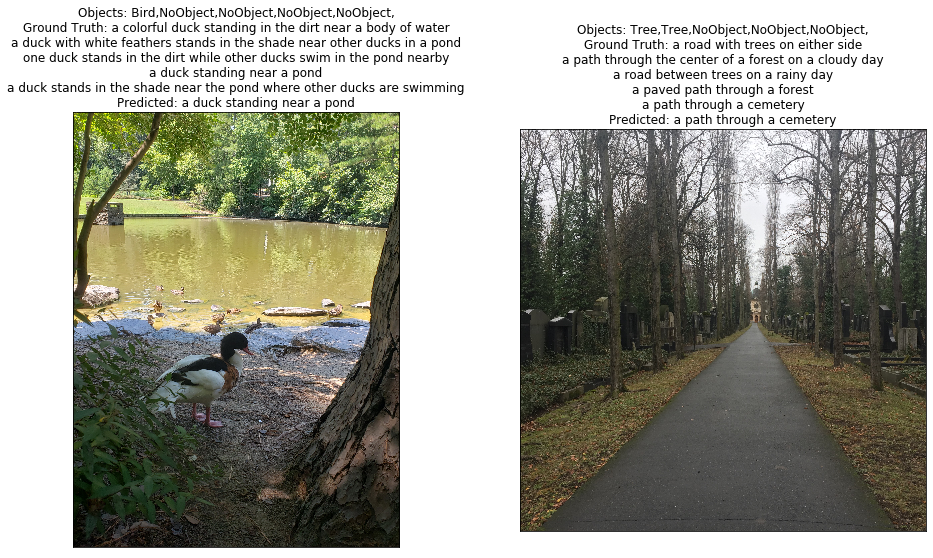

In [42]:
image_path = 'imageCaptioning_images'
display_predicted_image_captions(conn,results,npreds=2,ncol=2,img_path=image_path)